In [1]:
import osu_beatmap_parser as obp

import io
import time
import pickle
import random
import requests

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Constants
SKILLSET_LABELS = ["AIM", "STREAM", "ALT", "TECH", "SPEED", "RHYTHM"]
NUM_CLASSES = len(SKILLSET_LABELS)
INPUT_DIM = 12
MAX_SEQ_LEN = 124
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:",device)
torch.set_default_device(device)


with open("data/beatmap_data.pkl", "rb") as pkl:
    chiv_data = pickle.load(pkl)

beatmaps_set_id, beatmaps_id, beatmaps_data, beatmaps_extra_data, beatmaps_skill = zip(*[(l[0],l[1],l[2],l[3],l[4])for l in chiv_data])

X_train, X_test, Xtra_train, Xtra_test, y_train, y_test = train_test_split(beatmaps_data, beatmaps_extra_data, beatmaps_skill, test_size=0.05, stratify=beatmaps_skill)

Using Device: cuda


In [3]:
def one_hot_labels(label):
    empty = np.zeros(len(SKILLSET_LABELS))
    if label in SKILLSET_LABELS:
        idx = SKILLSET_LABELS.index(label)
        empty[idx] = 1
        return empty
    else:
        empty[-1] = 1
        return empty

def apply_dt(beatmap_sequence, extra_data):
    beatmap_sequence[:,5] *= 1.5
    beatmap_sequence[3:5] /= 1.5
    if extra_data[0] >= 5:
        extra_data[0] = min((extra_data[0]*2 + 13)/3,    11)
    else:
        extra_data[0] = max(extra_data[0]*400/750 + 5,   0)

def apply_ht(beatmap_sequence, extra_data):
    beatmap_sequence[:,5] *= 0.75
    beatmap_sequence[3:5] /= 0.75
    if extra_data[0] >= 5:
        extra_data[0] = min((extra_data[0]*2 + 13)/3,    11) #todo
    else:
        extra_data[0] = max(extra_data[0]*400/750 + 5,   0) #todo

def apply_hr(beatmap_sequence, extra_data):
    beatmap_sequence[:,1] = 1-beatmap_sequence[:,1]
    extra_data[0] = min(extra_data[0]*1.4, 10)

def apply_ez(beatmap_sequence, extra_data):
    extra_data[0] = extra_data[0]/2

def decode_output(tensor):
    return SKILLSET_LABELS[tensor.argmax()]

def create_beatmaps_batch(beatmaps_data, extra_data, labels, batch_size): #beatmaps_data and extra_data must match
    max_length = len(beatmaps_data)-1
    ids = [random.randint(0,max_length) for _ in range(batch_size)]
    swapx = random.random()
    swapy = random.random()
    swapx_ = False if swapx<0.5 else True
    swapy_ = False if swapy<0.5 else True
    batch = []
    y = []
    extra = []
    for id in ids:
        y.append(one_hot_labels(labels[id]))
        extra.append(extra_data[id])
        sequence_length = beatmaps_data[id].shape[0]-1
        start = random.randint(0,sequence_length-MAX_SEQ_LEN)
        beatmap = beatmaps_data[id][start:start+MAX_SEQ_LEN]

        if swapx_:
            beatmap[:,0] = 1-beatmap[:,0]
        swapx_ = not swapx_
        if swapy_:
            beatmap[:,1] = 1-beatmap[:,1]
        swapy_ = not swapy_
        
        batch.append(beatmap)
    return np.array(batch), np.array(extra), np.array(y)


def get_beatmap_from_website(id):
    url = f"https://osu.ppy.sh/osu/{id}"
    response = requests.get(url)
    if response.status_code == 200:
        text_file = io.StringIO(response.text.replace('\r', '')).readlines()
        beatmap = obp.Beatmap.str_to_beatmap(text_file)
    else:
        print("Could not get Beatmap with id: " + id)
        return None

    return beatmap

In [4]:
class SkillsetClassifier (nn.Module):
    def __init__(self, context_length:int, skillsets:int):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, (7,1)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (5,1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (5,1)),
            nn.ReLU(),
            nn.Conv2d(128, 256, (5,1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2,INPUT_DIM))
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*2*INPUT_DIM, 256*2*INPUT_DIM), # (context_length - convlayerunpadding(10+10+1)) * skillsets * 32conv
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256*2*INPUT_DIM, 256*INPUT_DIM),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256*INPUT_DIM, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, skillsets)
        )
    
    def forward(self, x, extra_x): # add extra input for metadata
        x = x.to(device)
        x = self.conv_block(x)
        x = self.flatten(x)
        #x = torch.concat((x,extra_x), dim=1)
        logits = self.linear_relu_stack(x)
        return logits
    

model = SkillsetClassifier(MAX_SEQ_LEN, NUM_CLASSES)
#criterion = nn.BCEWithLogitsLoss()  #alternative loss function for multiclass
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

#loads model weights
PATH = "model_weights/osu_skills_v2.pth"
model.load_state_dict(torch.load(PATH,weights_only=True))


<All keys matched successfully>

In [5]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,130], gamma=0.1)

X_test_, Xtra_test_, y_test_ = create_beatmaps_batch(X_test, Xtra_test, y_test, len(y_test))
X_test_ = torch.tensor(X_test_, dtype=torch.float32)
Xtra_test_ = torch.tensor(Xtra_test_, dtype=torch.float32)
y_test_ = torch.tensor(y_test_, dtype=torch.float32)
X_test_ = X_test_.unsqueeze(1)

def train(model, epoch_length:int=4000, epochs:int=50, model_path:str="osu_skills_v2"):
    test_loss = 1e10
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(epoch_length):
            # get the inputs; data is a list of [inputs, labels]
            inputs, extra, y = create_beatmaps_batch(X_train, Xtra_train, y_train, BATCH_SIZE)
            inputs = torch.tensor(inputs, dtype=torch.float32)
            inputs = inputs.unsqueeze(1) #for the cnn channels
            extra =  torch.tensor(extra, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            # zero the parameter gradients
            #print(torch.isnan(inputs).any(), torch.isinf(inputs).any())
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs, extra)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / epoch_length:.3f}')
        scheduler.step()


        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_, Xtra_test_)
            val_loss = criterion(y_pred, y_test_)
            if val_loss<test_loss:
                test_loss = val_loss
                if model_path:
                    torch.save(model.state_dict(), f"model_weights/{model_path}.pth")
        print(f"Test val_loss: {val_loss}")
        model.train()

    print('Finished Training')


#train(model, epochs=150)

In [6]:
def visualize_beatmap_skillsets(model, beatmap:obp.Beatmap, dt:bool=False):
    def median_filter_columns(x: torch.Tensor, kernel_size: int) -> torch.Tensor:
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        pad = kernel_size // 2
        
        # Expand to 3D: (1, rows, columns)
        x_3d = x.unsqueeze(0)
        # Pad the rows (dim=1), no padding on columns (dim=2)
        x_padded = f.pad(x_3d, (0, 0, pad, pad), mode='reflect')
        x_padded = x_padded.squeeze(0)  # Back to 2D

        # Unfold rows
        windows = x_padded.unfold(dimension=0, size=kernel_size, step=1)
        return windows.median(dim=2).values

    beatmap_sequence, extra = beatmap.beatmap_to_data()
    if dt:
        apply_dt(beatmap_sequence, extra)
            
    beatmap_sequence = torch.tensor(beatmap_sequence, dtype=torch.float32)
    extra = torch.tensor(extra, dtype=torch.float32)
    #print(extra)
    skillspread = []
    step_size = MAX_SEQ_LEN//20
    skillvals = torch.zeros(((beatmap_sequence.shape[0]-MAX_SEQ_LEN)//step_size+1,len(SKILLSET_LABELS)))
    for i,j in enumerate(range(0,beatmap_sequence.shape[0]-MAX_SEQ_LEN-1,step_size)):
        #print(beatmap_sequence[None,j:j+MAX_SEQ_LEN,:].shape)
        prediction = model(beatmap_sequence[None,None,j:j+MAX_SEQ_LEN,:], extra[None,:])
        skillvals[i] = prediction
        skillspread.append(decode_output(prediction))

    
    sm = nn.Softmax(dim=-1)
    kernel_size=5

    skillvals_filtered = median_filter_columns(skillvals, kernel_size)
    skillvals_filtered = torch.round(skillvals_filtered, decimals=1)
    skillvals_filtered = sm(skillvals_filtered)

    #time = [b.hit_object.time for b in beatmap.beatmap_objects]
    max_time = max(map(lambda b: b.hit_object.time, beatmap.beatmap_objects))
    min_time = min(map(lambda b: b.hit_object.time, beatmap.beatmap_objects))
    b_time = np.linspace(min_time,max_time, len(skillvals_filtered))
    b_time = b_time/1000/60

    skillvaluespread = skillvals_filtered.cpu().detach().numpy()
    bottom = np.zeros(len(b_time))

    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in range(len(SKILLSET_LABELS))]

    fig = plt.figure(figsize=(18, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])
    fig.suptitle(beatmap.metadata.title)

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.grid(color="gray", linestyle="--", alpha=0.2)
    ax1.margins(x=0, y=0)
    ax1.set_ylim(0,1)

    for i,la in enumerate(SKILLSET_LABELS):
        ax1.plot(b_time,skillvaluespread[:,i], label=la)
        ax1.fill_between(b_time, skillvaluespread[:,i],bottom, alpha=0.2)
    ax1.set_xticks((np.linspace(min(b_time),max(b_time),15)).round(2))
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    ax2 = fig.add_subplot(gs[1, 1])
    ax2.stackplot(b_time,
                       skillvaluespread[:,0],skillvaluespread[:,1],skillvaluespread[:,2],skillvaluespread[:,3],
                       skillvaluespread[:,4],skillvaluespread[:,5],
                       labels=SKILLSET_LABELS, baseline="zero", alpha=0.9, edgecolor="black", linewidth=1)
    ax2.set_xticks((np.linspace(min(b_time),max(b_time),15)).round(2))
    ax2.grid(color="gray", linestyle="--", alpha=0.1)
    ax2.margins(x=0, y=0)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    ax3 = fig.add_subplot(gs[:, 0])
    ax3.barh(y=SKILLSET_LABELS, width=np.sum(skillvaluespread, axis=0)/np.sum(skillvaluespread), color=colors, edgecolor="black")
    ax3.invert_yaxis()
    ax3.invert_xaxis()
    yticklabels = ax3.get_yticklabels()
    for label, color in zip(yticklabels, colors):
        label.set_color(color)
        label.set_fontsize('x-large')
    #ax3.yaxis.set_label_position("right")
    #ax3.yaxis.tick_right()

    plt.tight_layout()
    plt.show()
    time.sleep(1)

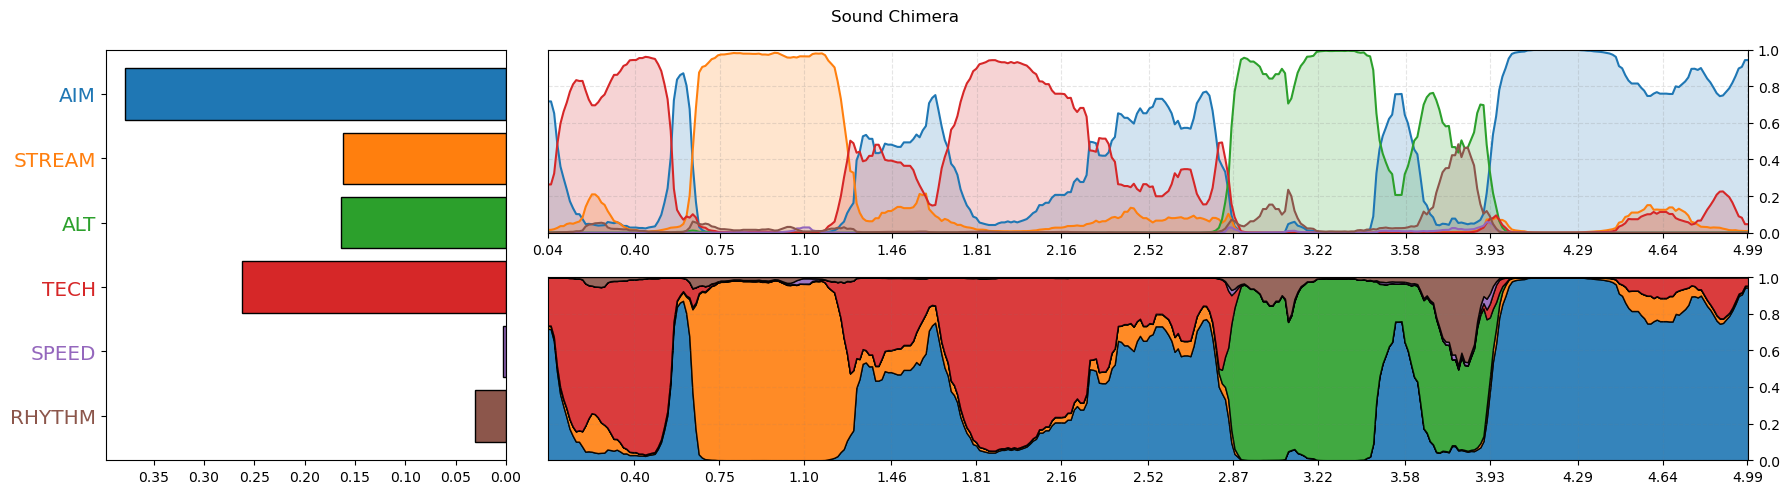

In [7]:
beatmap = obp.Beatmap.file_to_beatmap("E:\\osu!\\Songs\\Laur - Sound Chimera\\Laur - Sound Chimera (Nattu) [Chimera].osu")
visualize_beatmap_skillsets(model, beatmap)

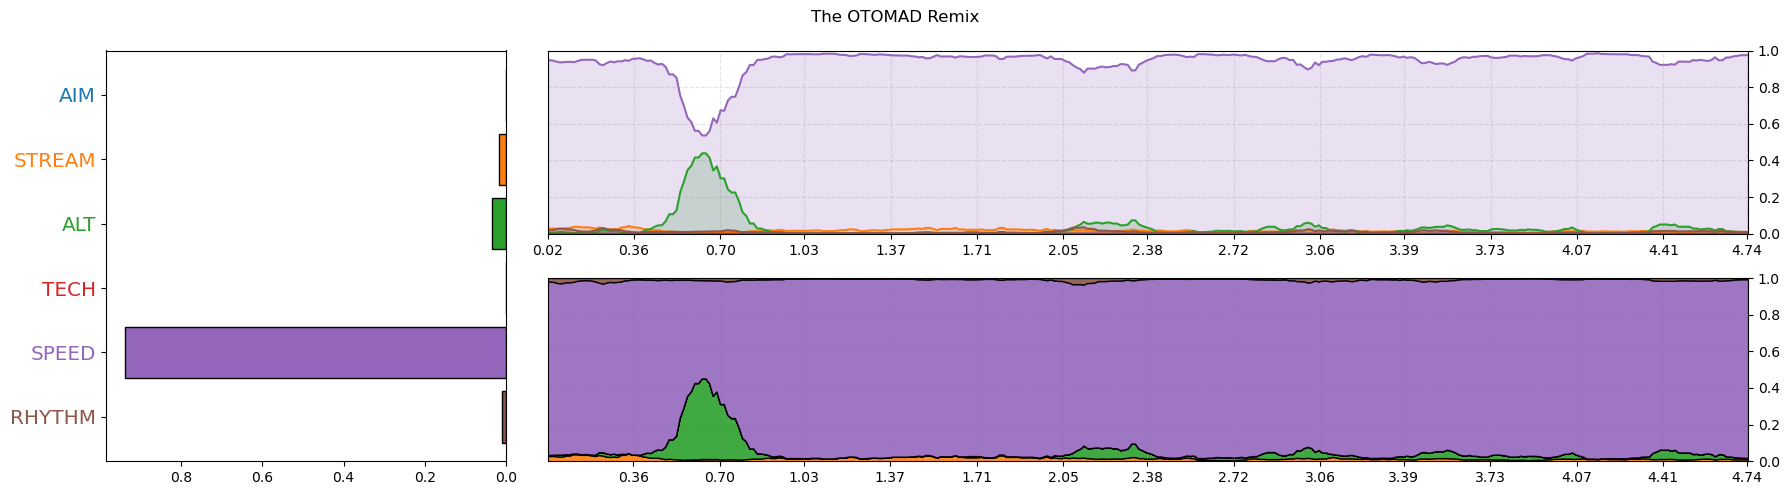

In [8]:
beatmap = get_beatmap_from_website(317460)
a = visualize_beatmap_skillsets(model, beatmap, dt=True)

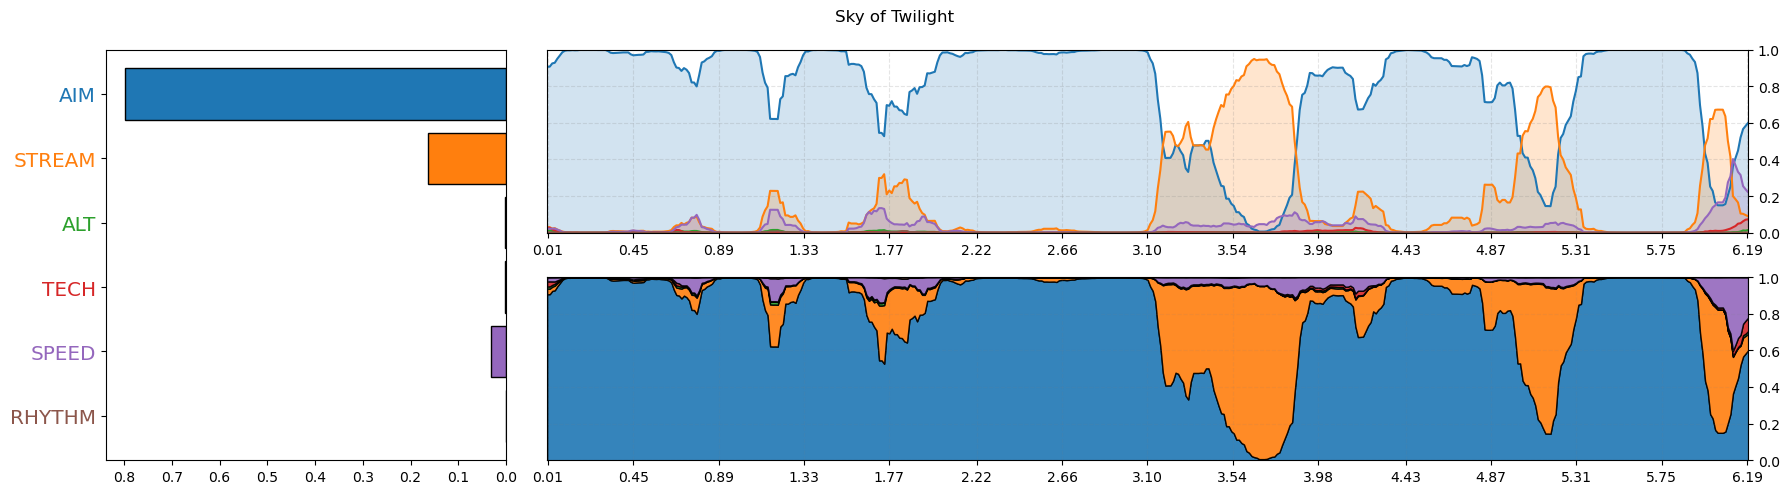

In [9]:
beatmap = get_beatmap_from_website(4881501)
visualize_beatmap_skillsets(model, beatmap)

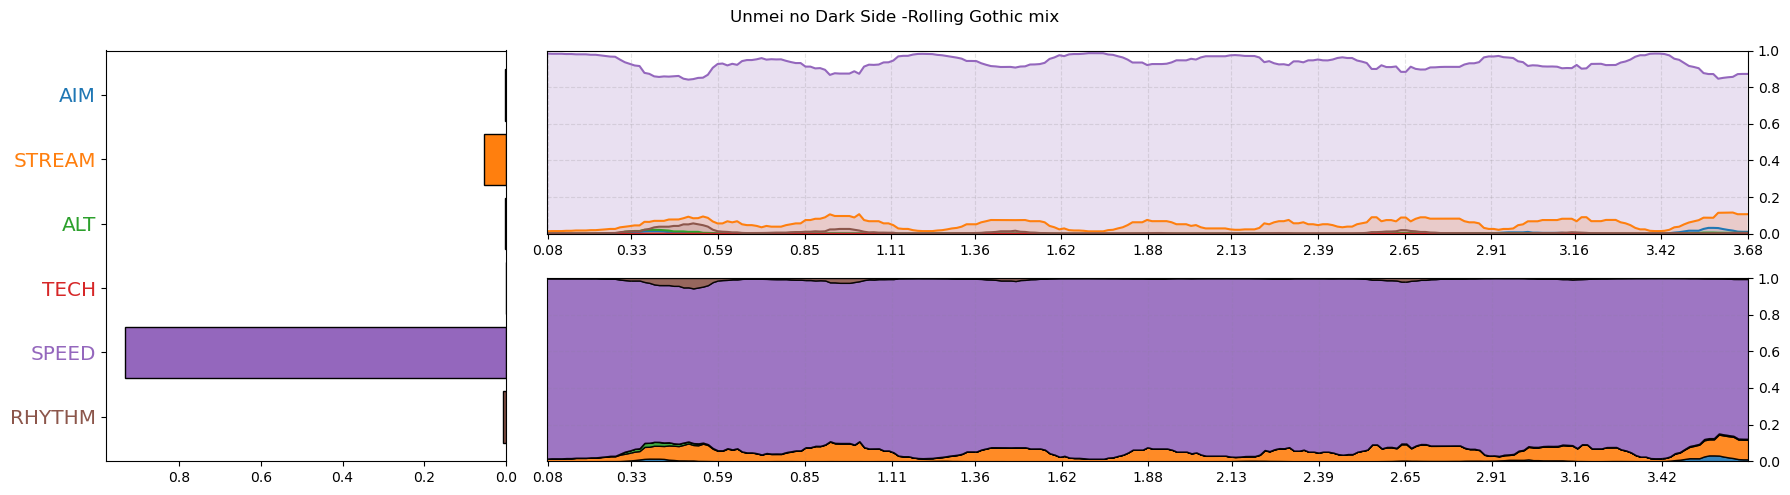

In [10]:
beatmap = get_beatmap_from_website(4881745)
visualize_beatmap_skillsets(model, beatmap, True)

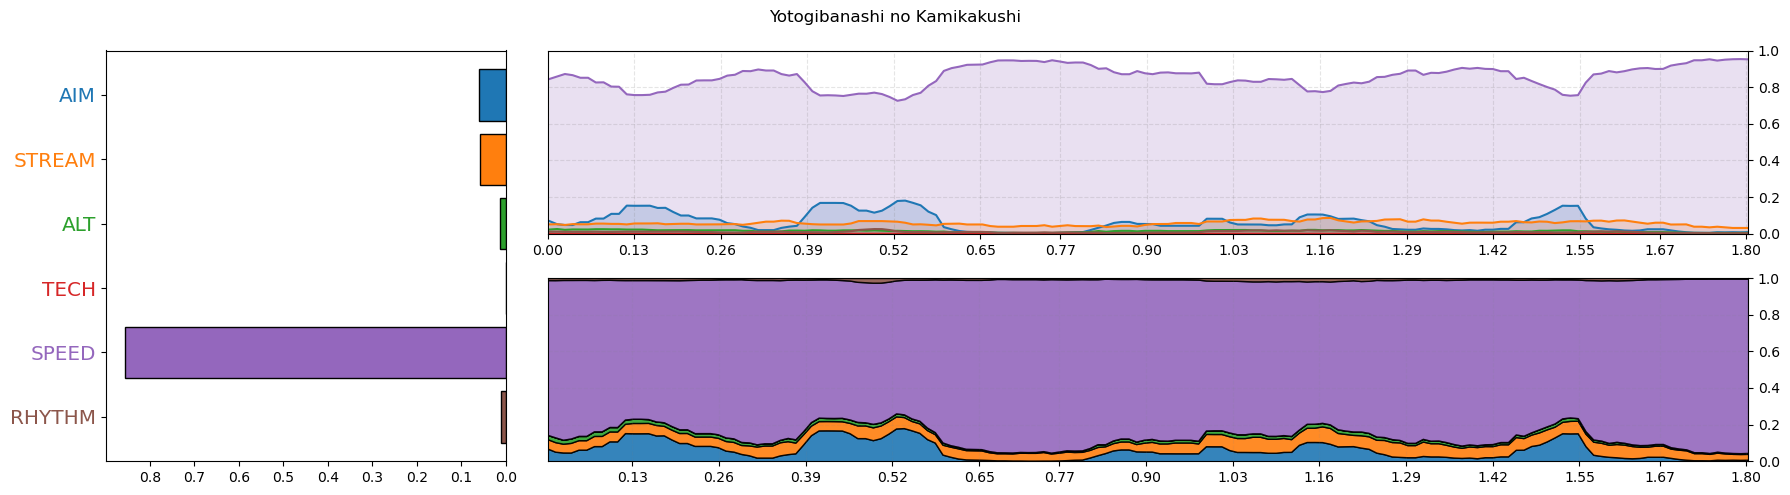

In [11]:
beatmap = get_beatmap_from_website(3933767)
visualize_beatmap_skillsets(model, beatmap, False)

In [12]:
# slidr1 = obp.Slider("61,102,959,6,0,P|328:151|462:363,1,500")
# slidr2 = obp.Slider("98,46,11446,2,0,B|262:148|279:254|428:343,2,400")
# slidr = obp.Slider("28,30,5454,2,0,B|215:145|215:145|217:230|217:230|265:217|292:179|292:179|310:206|360:192|360:192|259:298|496:349,5,700")
# timng = obp.TimingPoint("960,374.531835205993,4,2,0,91,1,0")
# beat_obj1 = obp.BeatMapObject(slidr1, timng, 374.531835205993)
# beat_obj = obp.BeatMapObject(slidr, timng, 374.531835205993)
# beat_obj2 = obp.BeatMapObject(slidr2, timng, 374.531835205993)


# oid = 0
# beatmap = obp.Beatmap(obp.Metadata("","","","",123,456),obp.Difficulty(6,4,7,8,2,1), [beat_obj])
# beatmap.beatmap_objects[oid].hit_object.draw_slider()
# ticks, end = beatmap.get_slider_ticks(beatmap.beatmap_objects[oid])
# plt.scatter(end[0], end[1], c="red")
# plt.scatter(np.array(beatmap.beatmap_objects[oid].hit_object.curve_points)[:,0],np.array(beatmap.beatmap_objects[oid].hit_object.curve_points)[:,1])
# plt.scatter(np.array(ticks)[:,0],np.array(ticks)[:,1], c="gray")
# plt.scatter(end[0], end[1], c="red")